In [1]:
import pandas as pd 
import numpy as np
import degree_codes as dc
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark-palette')
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.combine import SMOTETomek
from sklearn.neural_network import MLPClassifier
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from dmba import classificationSummary, gainsChart
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
import pprint
from sklearn.svm import SVC  

In [2]:
df=pd.read_csv('main_df.csv')
df.head(3)

,SEX,AGE,stemType,stemBinary,State,under_represented,domestic_born,EDU_verbose,is_STEM_degree,STEM_Degree_Area
0,0,53,-1,0,Wisconsin,0,1,High School,0,None
1,0,56,-1,0,New York,0,1,High School,0,None
2,1,35,-1,0,Pennsylvania,0,0,Bachelor,0,None


In [3]:
#selecting the feautures for modeling
df_model=df[[
    'SEX'
    #,'State'
    ,'AGE'
    ,'domestic_born'
    ,'EDU_verbose'
    ,'is_STEM_degree'
    ,'under_represented'
    ,'stemType'
    ,'STEM_Degree_Area'
]]
del df

In [4]:
df_model['stemType'].value_counts()

-1                                                                                 188145
Research, Development, Design, and Practitioners                                     4031
Other                                                                                1049
Managerial                                                                            768
Research, Development, Design, and Practitioners; Technologists and Technicians       612
Technologists and Technicians                                                         355
Sales                                                                                  39
Name: stemType, dtype: int64

In order to run any sort of modeling on stemType, our target variable, we have to binarize it by employing a lambda function. At this point, stemType indicates whether an individual works in STEM, rather than which STEM field they're employed in :

In [5]:
def binarize_stem(x):
    if x == '-1':
        return 0
    return 1

#binarize STEM
df_model['stemType'] = df_model['stemType'].map(binarize_stem)

df_model['stemType'].head(3)

0    0
1    0
2    0
Name: stemType, dtype: int64

In order to deploy our ML model online, we need to save a version of our full dataset that enables the user to define the value for each feature before we do encoding for EDU_verbose.

In [6]:
df_model.to_csv('streamlit/data.csv',index=None)

Given that there's several different levels of education, we would benefit from using dummy variables in our modeling for them:

In [7]:
a = pd.get_dummies(df_model['STEM_Degree_Area'],prefix='STEM_Degree_Area')
b = pd.get_dummies(df_model['EDU_verbose'],prefix='EDU_verbose')#get dummy variables for Education

frames = [
    df_model
    , a
    , b] # append them as a list
df_model = pd.concat(frames, axis = 1)
df_model=df_model.drop(columns = [
    'EDU_verbose',
    'STEM_Degree_Area'
]) 
df_model.head()

,SEX,AGE,domestic_born,is_STEM_degree,under_represented,stemType,STEM_Degree_Area_Agriculture,STEM_Degree_Area_Biology and Life Sciences,STEM_Degree_Area_Business,STEM_Degree_Area_Computer and Information Sciences,...,STEM_Degree_Area_Military Technologies,STEM_Degree_Area_None,"STEM_Degree_Area_Nuclear, Industrial Radiology, and Biological Technologies",STEM_Degree_Area_Physical Sciences,EDU_verbose_Associate,EDU_verbose_Bachelor,EDU_verbose_High School,EDU_verbose_Master,EDU_verbose_None/Below HS,EDU_verbose_PhD
0,0,53,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,0,56,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,1,35,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,0,30,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,0,47,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


Finally, to keep scale consistent, we would want to normalize the AGE variable to avoid giving it more weight. We can do this by subtracting the mean and dividing by the standard devation:

In [8]:
print(f"Age Std. Dev:{df_model['AGE'].std()}")
print(f"Mean Age:{df_model['AGE'].mean()}")

Age Std. Dev:18.939649284403245
Mean Age:50.02754885922492


In [9]:
df_model['AGE'] = (df_model['AGE']-df_model['AGE'].mean())/df_model['AGE'].std()
df_model['AGE'].head(3)

0    0.156943
1    0.315341
2   -0.793444
Name: AGE, dtype: float64

In [10]:
y=df_model['stemType']
y.value_counts()

0    188145
1      6854
Name: stemType, dtype: int64

### Check for class imbalance 

Percent of 0s: 96.49

Percent of 1s: 3.51


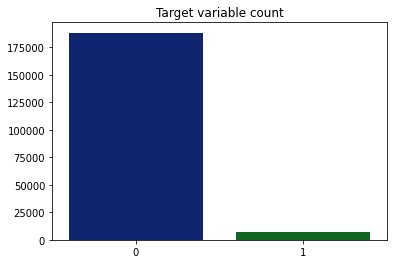

In [11]:
data = pd.DataFrame(df_model['stemType'])
percentage1 = round((data.stemType.sum() / data.shape[0]) * 100, 2) 
percentage0 = round(100 - percentage1, 2)
print('Percent of 0s:', percentage0)
print('\nPercent of 1s:', percentage1)
t=df_model['stemType'].value_counts().values
sns.barplot([0,1],t)
plt.title('Target variable count')
plt.show()

In [12]:
X = df_model.drop(columns=['stemType'])
y = df_model['stemType']
train_X, rem_X, train_y, rem_y = train_test_split(X, y, train_size=0.6, random_state=42, stratify = y)
valid_X, test_X, valid_y, test_y = train_test_split(rem_X, rem_y, train_size=0.5, random_state=42, stratify = rem_y) 

In [13]:
print('Training Set:\n', train_y.value_counts(), '\n', train_y.value_counts(normalize = True))
print('\nValidation Set:\n', valid_y.value_counts(), '\n', valid_y.value_counts(normalize = True))
print('\nTest Set:\n', test_y.value_counts(), '\n', test_y.value_counts(normalize = True))

Training Set:
 0    112887
1      4112
Name: stemType, dtype: int64 
 0    0.964854
1    0.035146
Name: stemType, dtype: float64

Validation Set:
 0    37629
1     1371
Name: stemType, dtype: int64 
 0    0.964846
1    0.035154
Name: stemType, dtype: float64

Test Set:
 0    37629
1     1371
Name: stemType, dtype: int64 
 0    0.964846
1    0.035154
Name: stemType, dtype: float64


In [14]:
try:
    train_X_res = pd.read_csv('SMOTE_df.csv')
    train_y_res = pd.read_csv('SMOTE_df_target.csv')
    print("pre-loaded datasets")
except:
    print("using SMOTE to rebalance...")
    # Fixing the class imbalance with tomekLinks and SMOTE
    SMOTEtl = SMOTETomek(random_state = 42)

    # fit predictor and target variable for training set only
    train_X_res, train_y_res = SMOTEtl.fit_resample(train_X, train_y)

    print('Original dataset shape:\n', train_y.value_counts())
    print('Resampled dataset shape:\n', train_y_res.value_counts())

    train_X_res.to_csv('SMOTE_df.csv',index=None)
    train_y_res.to_csv('SMOTE_df_target.csv',index=None)

pre-loaded datasets


In [15]:
train_X_res.head()

,SEX,AGE,domestic_born,is_STEM_degree,under_represented,STEM_Degree_Area_Agriculture,STEM_Degree_Area_Biology and Life Sciences,STEM_Degree_Area_Business,STEM_Degree_Area_Computer and Information Sciences,STEM_Degree_Area_Electrical and Mechanic Repairs and Technologies,...,STEM_Degree_Area_Military Technologies,STEM_Degree_Area_None,"STEM_Degree_Area_Nuclear, Industrial Radiology, and Biological Technologies",STEM_Degree_Area_Physical Sciences,EDU_verbose_Associate,EDU_verbose_Bachelor,EDU_verbose_High School,EDU_verbose_Master,EDU_verbose_None/Below HS,EDU_verbose_PhD
0,1,-1.374236,1,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,1,0.262542,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
2,0,-1.691032,1,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,1,-0.107053,1,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,0,0.156943,1,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


We can also save our SMOTE data to .csv to avoid having to re-run this data during development work for future replications, which is handled in the **except** statement above.

### Helper Function: Confusion Matrix

In [16]:
def confusionMatrices(model, title):
    print(title + ' - training results')
    classificationSummary(train_y_res, model.predict(train_X_res))
    print(title + ' - validation results')
    valid_pred = model.predict(valid_X)
    classificationSummary(valid_y, valid_pred)

### Helper Function: Evaluation Metrics

In [17]:
def evalMetrics(model,mod_predict,verbose=True):
    # precision tp / (tp + fp)
    precision = precision_score(test_y, mod_predict)
    # recall: tp / (tp + fn)
    recall = recall_score(test_y, mod_predict)
    
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(test_y, mod_predict)
    
    # ROC AUC
    mp = model.predict_proba(test_X)
    mp = mp[:, 1]
    auc = roc_auc_score(test_y, mp)
    
    if verbose:
        print('Precision: %f' % precision)
        print('Recall: %f' % recall)
        print('F1 score: %f' % f1)
        print('ROC AUC: %f' % auc)
        
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc":auc
    }

### Helper Function: Performance Plotting

In [18]:
def roc_vs(roc_scores,params,param_name):
    # plot
    plt.plot(params,roc_scores)
    max_roc = max(roc_scores)
    max_index = roc_scores.index(max_roc)
    
    try:
        max_param = round(params[max_index],4)
    except:
        max_param = params[max_index]
        
    max_roc = round(max_roc,4)
    plt.ylabel('roc-auc')
    plt.xlabel(param_name)
    plt.title(f'roc-auc score vs {param_name}, max roc:{max_roc}, parameter: {max_param}')
    plt.show()

### Naive Bayes

In [19]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(train_X_res, train_y_res)
confusionMatrices(gnb,'Naive Bayes')

Naive Bayes - training results
Confusion Matrix (Accuracy 0.7436)

       Prediction
Actual     0     1
     0 95181 17348
     1 40361 72168
Naive Bayes - validation results
Confusion Matrix (Accuracy 0.8374)

       Prediction
Actual     0     1
     0 31779  5850
     1   492   879


#### Evaluation and Confusion Matrix:

In [20]:
gnb_pred = gnb.predict(test_X)
evalMetrics(gnb,gnb_pred,False)

{'precision': 0.1338195891634415,
 'recall': 0.6557257476294676,
 'f1': 0.22227716652243787,
 'roc_auc': 0.8349474452667653}

### Logistic Regression - Initial Overview and Tuning

In [21]:
C_param_range = [0.001,0.01,0.1,1,10,100]
roc_scores = []
for c in C_param_range:

    logit_reg = LogisticRegression(
        penalty="elasticnet"
        , C=c
        , solver='saga'
        , random_state = 1
        , l1_ratio = 0.5
    )
    logit_reg.fit(train_X_res, train_y_res)
    #confusionMatrices(logit_reg, 'Logistic regression')
    logit_pred = logit_reg.predict(test_X)
    roc_scores.append(evalMetrics(logit_reg,logit_pred,False)['roc_auc'])

KeyboardInterrupt: 

In [ ]:
roc_vs(roc_scores,C_param_range,'Inverse Regularization Strength')

In [ ]:
l1_ratio = [0.1,0.15,0.2,0.25,0.3]
roc_scores = []
for l in l1_ratio:

    logit_reg = LogisticRegression(
        penalty="elasticnet"
        , C=0.1
        , solver='saga'
        , random_state = 1
        , l1_ratio = l
    )
    logit_reg.fit(train_X_res, train_y_res)
    #confusionMatrices(logit_reg, 'Logistic regression')
    logit_pred = logit_reg.predict(test_X)
    roc_scores.append(evalMetrics(logit_reg,logit_pred,False)['roc_auc'])

In [ ]:
roc_vs(roc_scores,l1_ratio,'L1 Ratio')

#### Deep Search

In [22]:
parameters = {
                'solver': ['lbfgs', 'liblinear', 'saga'],
                'penalty':['elasticnet', 'l1', 'l2'],
                'C':[0.1],
                'l1_ratio': [0.19,0.2,0.21],
                'random_state': [1]
             }



grid_search = GridSearchCV(
    estimator = LogisticRegression(random_state=1),  
    param_grid = parameters,
    scoring = 'roc_auc',
    cv = 5,
    verbose=1)


grid_search.fit(train_X_res, train_y_res)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=1),
             param_grid={'C': [0.1], 'l1_ratio': [0.19, 0.2, 0.21],
                         'penalty': ['elasticnet', 'l1', 'l2'],
                         'random_state': [1],
                         'solver': ['lbfgs', 'liblinear', 'saga']},
             scoring='roc_auc', verbose=1)

In [23]:
print(grid_search.best_estimator_)
evalMetrics(grid_search,grid_search.predict(test_X))

LogisticRegression(C=0.1, l1_ratio=0.19, random_state=1, solver='saga')
Precision: 0.132887
Recall: 0.709701
F1 score: 0.223858
ROC AUC: 0.850597


{'precision': 0.13288718929254303,
 'recall': 0.7097009482129832,
 'f1': 0.22385827677441622,
 'roc_auc': 0.8505973392691312}

### Random Forest - GridSearch

To optimize random forest performance, we want to cycle through the number of estimators, the maximum tree depth, the log-loss, the cost function, and more:

In [24]:
rf = RandomForestClassifier(random_state = 1,verbose = 2)

# Number of trees in random forest
n_estimators = [400,450,500,550,600]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint.pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [400, 450, 500, 550, 600]}


In [25]:
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(
    estimator = rf
    , param_distributions = random_grid
    , n_iter = 100
    , cv = 3
    , verbose=2
    , random_state=1
    , n_jobs = -1
    , scoring = 'roc_auc'
)
# Fit the random search model
rf_random.fit(train_X_res, train_y_res)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 450
building tree 2 of 450
building tree 3 of 450
building tree 4 of 450
building tree 5 of 450
building tree 6 of 450
building tree 7 of 450
building tree 8 of 450
building tree 9 of 450
building tree 10 of 450
building tree 11 of 450
building tree 12 of 450
building tree 13 of 450
building tree 14 of 450
building tree 15 of 450
building tree 16 of 450
building tree 17 of 450
building tree 18 of 450
building tree 19 of 450
building tree 20 of 450
building tree 21 of 450
building tree 22 of 450
building tree 23 of 450
building tree 24 of 450
building tree 25 of 450
building tree 26 of 450
building tree 27 of 450
building tree 28 of 450
building tree 29 of 450
building tree 30 of 450
building tree 31 of 450
building tree 32 of 450
building tree 33 of 450
building tree 34 of 450
building tree 35 of 450
building tree 36 of 450
building tree 37 of 450
building tree 38 of 450
building tree 39 of 450
building tree 40 of 450
building tree 41 of 450
building tree 42 of 450
b

building tree 335 of 450
building tree 336 of 450
building tree 337 of 450
building tree 338 of 450
building tree 339 of 450
building tree 340 of 450
building tree 341 of 450
building tree 342 of 450
building tree 343 of 450
building tree 344 of 450
building tree 345 of 450
building tree 346 of 450
building tree 347 of 450
building tree 348 of 450
building tree 349 of 450
building tree 350 of 450
building tree 351 of 450
building tree 352 of 450
building tree 353 of 450
building tree 354 of 450
building tree 355 of 450
building tree 356 of 450
building tree 357 of 450
building tree 358 of 450
building tree 359 of 450
building tree 360 of 450
building tree 361 of 450
building tree 362 of 450
building tree 363 of 450
building tree 364 of 450
building tree 365 of 450
building tree 366 of 450
building tree 367 of 450
building tree 368 of 450
building tree 369 of 450
building tree 370 of 450
building tree 371 of 450
building tree 372 of 450
building tree 373 of 450
building tree 374 of 450


[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:  1.2min finished


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(random_state=1, verbose=2),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [400, 450, 500, 550,
                                                         600]},
                   random_state=1, scoring='roc_auc', verbose=2)

We can see which parameters perform the best for our random forest:

Continue by reviewing the array of ROC scores we got from our models:

In [26]:
RandomForest_pred = rf_random.predict(test_X)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:    3.2s finished


In [27]:
evalMetrics(rf_random,RandomForest_pred)
classificationSummary(test_y, RandomForest_pred)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Precision: 0.146047
Recall: 0.467542
F1 score: 0.222569
ROC AUC: 0.760302
Confusion Matrix (Accuracy 0.8852)

       Prediction
Actual     0     1
     0 33881  3748
     1   730   641


[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:    3.2s finished


We can also compare this with our original model:

In [29]:
#current best roc ~ 83.7%
RandomForest = RandomForestClassifier(
    n_estimators=500 #current best = 500
    , random_state=1
    , max_depth = 6
)
RandomForest.fit(train_X_res, train_y_res)
RandomForest_pred = RandomForest.predict(test_X)
evalMetrics(RandomForest,RandomForest_pred)
classificationSummary(test_y, RandomForest_pred)

Precision: 0.133769
Recall: 0.702407
F1 score: 0.224737
ROC AUC: 0.857464
Confusion Matrix (Accuracy 0.8296)

       Prediction
Actual     0     1
     0 31393  6236
     1   408   963


it appears that despite our eforts to conduct some sort of gridsearch for our random forest model, we're unable to beat the roc of 83.7% using conventional means, and will have to approach this more carefully by tuning each metric alone until we get better insights.

#### 1. Number of Estimators

In [30]:
estimators = [125,150,175,200,225,250]
roc_scores = []

for e in estimators:
    RandomForest = RandomForestClassifier(
        n_estimators= e #current best = 500
        , random_state=1
        , max_depth = 6
    )
    RandomForest.fit(train_X_res, train_y_res)
    RandomForest_pred = RandomForest.predict(test_X)
    
    #get roc_auc
    this_roc = evalMetrics(RandomForest,RandomForest_pred,verbose=False)['roc_auc']
    roc_scores.append(this_roc)

#### 1b. Visualization

we can conclude that around 200 estimators is an optimal number for our random forest clasifier.

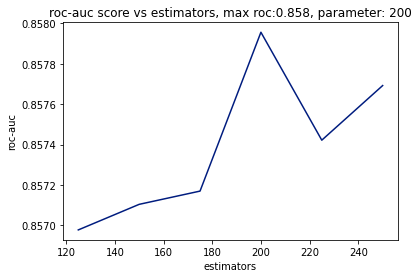

In [31]:
roc_vs(roc_scores,estimators,"estimators")

#### 2. max depth

In [32]:
depths = list(range(1,10))
roc_scores = []

for d in depths:
    RandomForest = RandomForestClassifier(
        n_estimators= 200 #current best = 500
        , random_state=1
        , max_depth = d
    )
    RandomForest.fit(train_X_res, train_y_res)
    RandomForest_pred = RandomForest.predict(test_X)
    
    #get roc_auc
    this_roc = evalMetrics(RandomForest,RandomForest_pred,verbose=False)['roc_auc']
    roc_scores.append(this_roc)

#### 2b. Visualization

a max depth of 7 seems to be an optimal parameter at this stage.

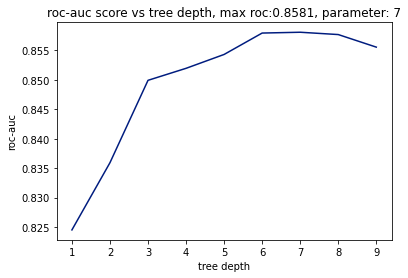

In [33]:
roc_vs(roc_scores,depths,"tree depth")

#### 3. Min sample split

In [34]:
min_samples_split = list(range(22,40,2))
roc_scores = []

for m in min_samples_split:
    RandomForest = RandomForestClassifier(
        n_estimators= 200
        , random_state=1
        , max_depth = 7
        , min_samples_split = m
    )
    RandomForest.fit(train_X_res, train_y_res)
    RandomForest_pred = RandomForest.predict(test_X)
    
    #get roc_auc
    this_roc = evalMetrics(RandomForest,RandomForest_pred,verbose=False)['roc_auc']
    roc_scores.append(this_roc)

#### 3b. Visualization
Optimal performance seems to be at a min-sample split of 22.

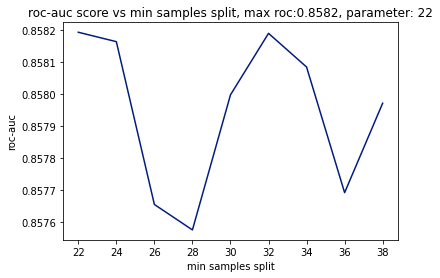

In [35]:
roc_vs(roc_scores,min_samples_split,"min samples split")

#### 4. Min samples per leaf

In [36]:
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,5,10,20,30,40,50,60,70,80,90,100,150,175,200,250,300]
roc_scores = []

for m in min_samples_leaf:
    RandomForest = RandomForestClassifier(
        n_estimators= 200
        , random_state=1
        , max_depth = 7
        , min_samples_split = 22
        , min_samples_leaf=m
    )
    RandomForest.fit(train_X_res, train_y_res)
    RandomForest_pred = RandomForest.predict(test_X)
    
    #get roc_auc
    this_roc = evalMetrics(RandomForest,RandomForest_pred,verbose=False)['roc_auc']
    roc_scores.append(this_roc)

#### 4b. Visualization
150 samples per leaf at a minimum is an optimal parameter.

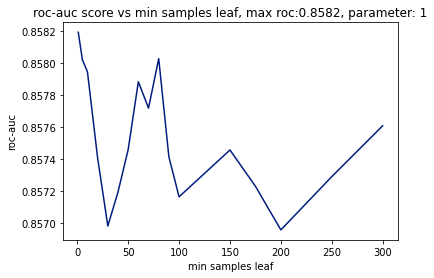

In [37]:
roc_vs(roc_scores,min_samples_leaf,"min samples leaf")

#### 5. criterion for splitting

In [38]:
# Minimum number of samples required at each leaf node
criteria = ["gini","entropy","log_loss"]
roc_scores = []

for c in criteria:
    RandomForest = RandomForestClassifier(
        n_estimators= 200
        , random_state=1
        , max_depth = 7
        , min_samples_split = 24
        , min_samples_leaf=1
        , criterion = c 
    )
    RandomForest.fit(train_X_res, train_y_res)
    RandomForest_pred = RandomForest.predict(test_X)
    
    #get roc_auc
    this_roc = evalMetrics(RandomForest,RandomForest_pred,verbose=False)['roc_auc']
    roc_scores.append(this_roc)

#### 5b. Visualization
In conclusion, any criterion except gini is sufficient for optimization.

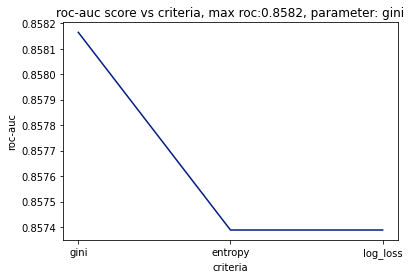

In [39]:
roc_vs(roc_scores,criteria,"criteria")

#### Conclusion
Despite several different layers of optimization work, the final conclusion for our random forest model is an ROC-AUC of 85.8%.

### Neural Network

In [ ]:
neuralNet = MLPClassifier(
    hidden_layer_sizes=(5)
    , activation='logistic'
    , solver='adam'
    , max_iter=2000, 
    random_state=1
)
neuralNet.fit(train_X_res, train_y_res)

In [41]:
neuralNet_pred = neuralNet.predict(test_X)
classificationSummary(test_y, neuralNet_pred )
evalMetrics(neuralNet,neuralNet_pred)

Confusion Matrix (Accuracy 0.8424)

       Prediction
Actual     0     1
     0 31893  5736
     1   411   960
Precision: 0.143369
Recall: 0.700219
F1 score: 0.238007
ROC AUC: 0.860603


{'precision': 0.14336917562724014,
 'recall': 0.700218818380744,
 'f1': 0.23800669393826698,
 'roc_auc': 0.8606030557580683}

Our neural network has an roc-auc of 84%, which is very similar to our random forest model. Here, we can take some steps to optimize our neural network by changing the number of hidden layers, the number of units, the learning rate, and more.

#### 1. Hidden Layer Units

In [44]:
sizes = [3,4,5,6,7,10]
roc_scores = []

for size in sizes:
    neuralNet = MLPClassifier(
        hidden_layer_sizes=(size)
        , activation='logistic'
        , solver= 'adam'#'lbfgs'
        , max_iter=2000, 
        random_state=1
    )
    neuralNet.fit(train_X_res, train_y_res)
    #confusionMatrices(neuralNet, 'Neural Network')
    neuralNet_pred = neuralNet.predict(test_X)
    this_roc = evalMetrics(neuralNet,neuralNet_pred,verbose=False)['roc_auc']
    roc_scores.append(this_roc)

#### 1b. Visualization
Having 5 nodes in our hidden layer creates the best performance.

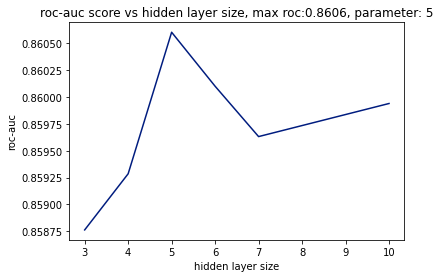

In [45]:
# plot
roc_vs(roc_scores,sizes,"hidden layer size")

#### 2b. Visualization

100 iterations is ideal for optimizing our roc-auc scores.
The code for this section has been discarded on account of the fact that, under no circumstances, did modifying the number of max iterations create any chance in performance.

#### 3. Alpha Selection 
Context: In this model, the Alpha is the strength of the L2 regularization, which removes a small portion of the weights without ever going down to zero.

In [78]:
alphas =  [0.00125,0.002,0.00215,0.00225,0.0025,0.003]
roc_scores = []

for alpha in alphas:
    neuralNet = MLPClassifier(
        hidden_layer_sizes=(5)
        , activation='logistic'
        , solver='adam'
        , max_iter=100
        , alpha = alpha
        , random_state=1
    )
    neuralNet.fit(train_X_res, train_y_res)
    #confusionMatrices(neuralNet, 'Neural Network')
    neuralNet_pred = neuralNet.predict(test_X)
    this_roc = evalMetrics(neuralNet,neuralNet_pred,verbose=False)['roc_auc']
    roc_scores.append(this_roc)

#### 3b. Visualization

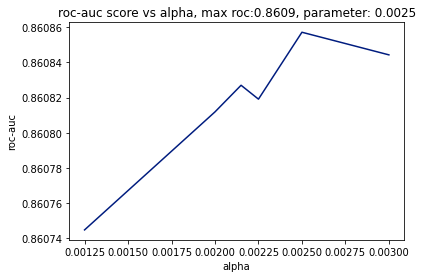

In [79]:
# plot
roc_vs(roc_scores,alphas,'alpha')

#### 4. Adam: Beta-1

In [80]:
beta_ones = [0.80,0.85,0.875,0.9,0.925,0.95]
roc_scores = []

for b in beta_ones:
    
    neuralNet = MLPClassifier(
        hidden_layer_sizes = (5)
        , activation       = 'logistic'
        , solver           = 'adam'
        , max_iter         = 100
        , alpha            = 0.0025
        , beta_1           = b
        , random_state     = 1
    )
    
    neuralNet.fit(train_X_res, train_y_res)
    #confusionMatrices(neuralNet, 'Neural Network')
    neuralNet_pred = neuralNet.predict(test_X)
    this_roc = evalMetrics(neuralNet,neuralNet_pred,verbose=False)['roc_auc']
    roc_scores.append(this_roc)

#### 4b. Visualization

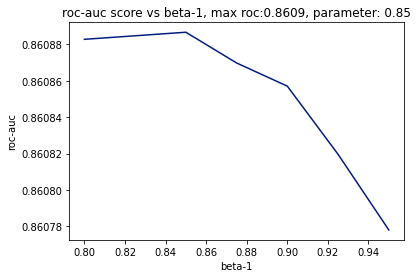

In [81]:
# plot
roc_vs(roc_scores,beta_ones,'beta-1')

#### 5. Activation Function

In [100]:
acs = ['identity','logistic','tanh','relu']
roc_scores = []

for ac in acs:
    neuralNet = MLPClassifier(
        hidden_layer_sizes=(5)
        , activation=ac
        , solver='adam'
        , max_iter=100
        , alpha = 0.0025
        , beta_1 = 0.85
        , random_state=1
    )
    neuralNet.fit(train_X_res, train_y_res)
    #confusionMatrices(neuralNet, 'Neural Network')
    neuralNet_pred = neuralNet.predict(test_X)
    this_roc = evalMetrics(neuralNet,neuralNet_pred,verbose=False)['roc_auc']
    roc_scores.append(this_roc)

#### 5b. Visualization

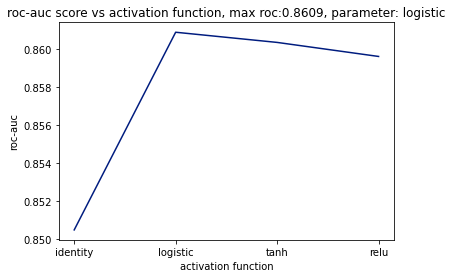

In [101]:
roc_vs(roc_scores,acs,'activation function')

#### 6. Epsilon

In [102]:
epsilons = [float(x) for x in np.linspace(1e-10,1e-8, num = 10)] 
roc_scores = []
for e in epsilons:
    neuralNet = MLPClassifier(
        hidden_layer_sizes=(5)
        , activation='logistic'
        , solver='adam'
        , max_iter=100
        , alpha = 0.0025
        , beta_1 = 0.85
        , random_state=1
        , epsilon = e 
    )
    neuralNet.fit(train_X_res, train_y_res)
    #confusionMatrices(neuralNet, 'Neural Network')
    neuralNet_pred = neuralNet.predict(test_X)
    this_roc = evalMetrics(neuralNet,neuralNet_pred,verbose=False)['roc_auc']
    roc_scores.append(this_roc)

#### 6b. Visualization

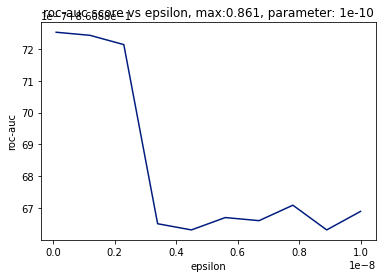

In [103]:
# plot - we dont use the wrapper because of how small the values are 
plt.plot(epsilons,roc_scores)
max_roc = max(roc_scores)
max_index = roc_scores.index(max_roc)
max_param = epsilons[max_index]
max_roc = round(max_roc,3)
plt.title(f'roc-auc score vs epsilon, max:{max_roc}, parameter: {max_param}')
plt.ylabel('roc-auc')
plt.xlabel('epsilon')
plt.show()

### Final Models Based on Tuning

#### Logistic Regression

In [84]:
lr = LogisticRegression(C=0.1, l1_ratio=0.19, random_state=1, solver='saga')
lr.fit(train_X_res,train_y_res)
lr

LogisticRegression(C=0.1, l1_ratio=0.19, random_state=1, solver='saga')

In [85]:
logit_pred = lr.predict(test_X)
lr_probs = lr.predict_proba(test_X)

#### Naive Bayes

In [86]:
gnb = GaussianNB()
gnb.fit(train_X_res,train_y_res)
gnb

GaussianNB()

In [87]:
gnb_pred = gnb.predict(test_X)
gnb_probs = gnb.predict_proba(test_X)

#### Random Forest

In [88]:
rf = RandomForestClassifier(
        n_estimators= 200
        , random_state=1
        , max_depth = 7
        , min_samples_split = 24
        , min_samples_leaf=1
        , criterion = c 
    )
rf.fit(train_X_res,train_y_res)
rf

RandomForestClassifier(criterion='log_loss', max_depth=7, min_samples_split=24,
                       n_estimators=200, random_state=1)

In [89]:
RandomForest_pred = rf.predict(test_X)
rf_probs = rf.predict_proba(test_X)

#### Neural Network

In [104]:
neuralNet = MLPClassifier(
    hidden_layer_sizes=(5)
    , activation='logistic'
    , solver='adam'
    , max_iter=100
    , alpha = 0.0025
    , beta_1 = 0.85
    , random_state=1
    , epsilon = 1e-10
)
neuralNet.fit(train_X_res,train_y_res)
neuralNet

MLPClassifier(activation='logistic', alpha=0.0025, beta_1=0.85, epsilon=1e-10,
              hidden_layer_sizes=5, max_iter=100, random_state=1)

In [105]:
neuralNet_pred = neuralNet.predict(test_X)
nn_probs = neuralNet.predict_proba(test_X)

In [106]:
table = {'Models':["Logistic Regression", 
                   "Random Forest",
                   "Neural Network",
                   "Naive Bayes"],
         'Accuracy':[accuracy_score(test_y, logit_pred), 
                     accuracy_score(test_y, RandomForest_pred),
                     accuracy_score(test_y, neuralNet_pred),
                     accuracy_score(test_y, gnb_pred)],
         'Precision':[precision_score(test_y, logit_pred),
                      precision_score(test_y, RandomForest_pred),
                      precision_score(test_y, neuralNet_pred), 
                      precision_score(test_y, gnb_pred)
                     ],
         "Recall":[recall_score(test_y, logit_pred),
                   recall_score(test_y, RandomForest_pred),
                   recall_score(test_y,neuralNet_pred),
                   recall_score(test_y,gnb_pred)
                  ],
         "F1_Score":[f1_score(test_y, logit_pred),
                     f1_score(test_y, RandomForest_pred),
                     f1_score(test_y,neuralNet_pred),
                     f1_score(test_y,gnb_pred)
                    ],
         "ROC AUC":[roc_auc_score(test_y, lr_probs[:, 1]),
                    roc_auc_score(test_y, rf_probs[:, 1]),
                    roc_auc_score(test_y,  nn_probs[:, 1]),
                    roc_auc_score(test_y, gnb_probs[:, 1])
                   ]
}
table_report = pd.DataFrame(table)
# print the data
table_report

,Models,Accuracy,Precision,Recall,F1_Score,ROC AUC
0,Logistic Regression,0.827000,0.132887,0.709701,0.223858,0.850597
1,Random Forest,0.837179,0.139464,0.702407,0.232721,0.857389
2,Neural Network,0.842949,0.143628,0.698760,0.238279,0.860887
3,Naive Bayes,0.838692,0.133820,0.655726,0.222277,0.834947


Our team chose to optimize on ROC-AUC score, with parsimony as a major consideration. In this case, we select the Random Forest model for its performance relative to the Neural Net on ROC, its relatively high accuracy and precision, high recall, and F1-Score.

In [108]:
import pickle
filename = 'finalized_rf_model.pkl'
pickle.dump(rf, open(filename, 'wb'))

In [109]:
#sanity check - reload form pickle
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model

RandomForestClassifier(criterion='log_loss', max_depth=7, min_samples_split=24,
                       n_estimators=200, random_state=1)